In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
spark.stop()

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext,SQLContext
#spark = SparkContext()

In [0]:
sc.stop()

In [0]:
sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

**Reading data from s3 buckets**

In [0]:
input_data="s3://nikhifinalproj6007/devicestatus.txt"

In [0]:
data = sc.textFile(input_data)
parts = data.map(lambda l: l.split("\t"))
# Each line is converted to a tuple.
devicestatus = parts.map(lambda p: (float(p[0]),float(p[1]),StringType(p[2]),StringType(p[3]),StringType(p[4]).strip()))
devicestatus =final_data.filter(lambda p: p[0]!=0 and p[1]!=0)

In [0]:
devicestatus.take(3)

[(33.6894754264, -117.543308253, '2014-03-15:10:10:20', 'Sorrento', 'F41L'),
 (37.4321088904, -121.485029632, '2014-03-15:10:10:20', 'MeeToo', '1.0'),
 (39.4378908349, -120.938978486, '2014-03-15:10:10:20', 'MeeToo', '1.0')]

**creating sparkdataframe**

In [0]:
from pyspark.sql import types
ds_df = spark.createDataFrame(devicestatus, schema=types.StructType([types.StructField('latitude', types.FloatType(),True),types.StructField('longtitude', types.FloatType(),True),types.StructField('datestr', types.StringType(),True),types.StructField('manufacturer', types.StringType(),True),types.StructField('model_name', types.StringType(),True)]))
                                                        
                                                        
                                                        
                                                        
                                                        


In [0]:
output_bucket="s3://nikhifinalproj6007/parsed_data"

In [0]:
df.rdd.coalesce(1).saveAsTextFile(output_bucket)

In [0]:
timetable=[]

In [0]:
inputbucket="s3://nikhifinalproj6007/parsed_data/"

In [0]:
data = sc.textFile(inputbucket)

In [0]:
print(data.take(1))

["Row(latitude=33.689476013183594, longtitude=-117.54330444335938, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F41L')"]


In [0]:
import re
%time
replacement=""
pattern="[A-Za-z\(]+="
data = data.map(lambda x: ( re.sub(pattern,replacement,x).replace(')','') )  )\
.map(lambda x: x.replace("'","").split(", "))\
.map(lambda x: ( float(x[0]), float(x[1]), x[2] , x[3], x[4]  ))

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 17.4 µs


In [0]:
data.cache()

PythonRDD[19] at RDD at PythonRDD.scala:53

In [0]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True),
                                                        types.StructField('date', types.StringType(),True),
                                                        types.StructField('manufacturer', types.StringType(),True),
                                                          types.StructField('model', types.StringType(),True)

]))

In [0]:
df.cache()

DataFrame[latitude: float, longitude: float, date: string, manufacturer: string, model: string]

https://spark.apache.org/docs/latest/ml-clustering.html

**kmeans model K=5**

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X = vecAssembler.transform(df)

#Trains a k-means model.
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(X)
# Make predictions
predictions = model.transform(X)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))
timetable.append((time.time() - start_time))

Silhouette with squared euclidean distance = 0.7779851895575357
Cluster Centers: 
[  38.02864791 -121.23352192]
[  34.29718423 -117.78653245]
[  43.98989868 -122.77665336]
[  34.58818551 -112.35533553]
[  42.25924472 -116.90267328]
--- 12.97334909439087 seconds ---


In [0]:
predictions = predictions.rdd.map(lambda x: (x[0],x[1],x[6],float(centers[x[6]][0]),float(centers[x[6]][1])))
predictions_df = spark.createDataFrame(predictions, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)

]))

In [0]:
predictions_df.show(3)

+-----------------+------------------+----------+---------------+----------------+
|original_latitude|original_longitude|prediction|center_latitude|center_longitude|
+-----------------+------------------+----------+---------------+----------------+
|        33.689476|       -117.543304|         1|      34.297184|      -117.78653|
|         37.43211|        -121.48503|         0|       38.02865|      -121.23352|
|         39.43789|        -120.93898|         0|       38.02865|      -121.23352|
+-----------------+------------------+----------+---------------+----------------+
only showing top 3 rows



**code for calculating Great circle distance and euclidean**

https://gist.github.com/pavlov99/bd265be244f8a84e291e96c5656ceb5c

In [0]:
import pyspark.sql.functions as F
predictions_df_with_gcd = predictions_df.withColumn("a", pow(sin(toRadians(F.col("center_latitude") -F.col( "original_latitude")) / 2), 2) + cos(toRadians(F.col("origin_latitude"))) * cos(toRadians(F.col("centre_latitude"))) * pow(sin(toRadians(F.col("centre_longitude") - F.col("origin_longitude")) / 2), 2))
  .withColumn("gc_dist", atan2(sqrt(F.col("a")), sqrt(-F.col("a") + 1)) * 2 * 6371)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )
                

In [0]:
predictions_df_with_gcd.show(3)

+-----------------+------------------+----------+---------------+----------------+-----------------+-------------------+
|original_latitude|original_longitude|prediction|center_latitude|center_longitude|          gc_dist|            eu_dist|
+-----------------+------------------+----------+---------------+----------------+-----------------+-------------------+
|        33.689476|       -117.543304|         1|      34.297184|      -117.78653|35.59862841593989|0.42846743379777763|
|         37.43211|        -121.48503|         0|       38.02865|      -121.23352|34.96130983668151|0.41911582615284715|
|         39.43789|        -120.93898|         0|       38.02865|      -121.23352|79.38456955250766| 2.0727134647313505|
+-----------------+------------------+----------+---------------+----------------+-----------------+-------------------+
only showing top 3 rows



In [0]:
predictions_df_with_gcd.rdd.cache()
predictions_df_with_gcd.rdd.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
predictions_df_with_gcd.registerTempTable("predictions_df_with_gcd")

**converting into pandas dataframe**

In [0]:
pandas_df = predictions_df_with_gcd.select("*").toPandas()

In [0]:
pandas_df.head()

original_latitude  original_longitude  ...        gc_dist   eu_dist
0          33.689476         -117.543304  ...   71197.256832  0.428467
1          37.432110         -121.485031  ...   69922.619673  0.419116
2          39.437889         -120.938980  ...  158769.139105  2.072713
3          39.363518         -119.400337  ...  217572.521626  5.142437
4          33.191357         -116.448242  ...  174441.922530  3.013867

[5 rows x 7 columns]

In [0]:
collected_array = np.array(pandas_df)

**visualization**

https://mubaris.com/posts/kmeans-clustering/

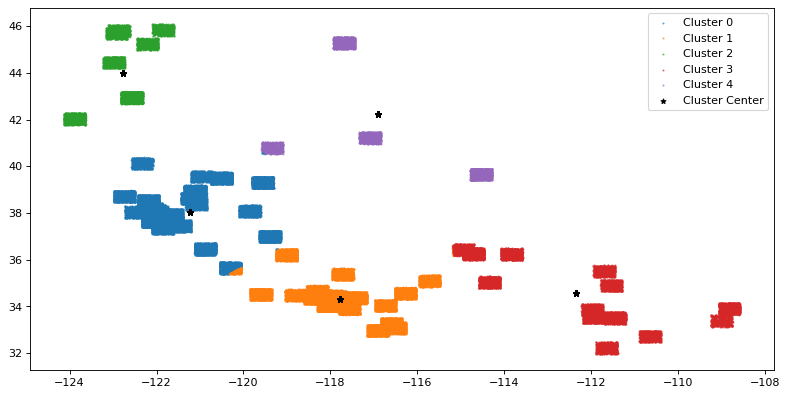

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
k=5
for i in range(k):
    points = np.array(pandas_df.prediction == i])
    plt.scatter(pandas_df.original_longitude[points],pandas_df.original_latitude[points],label="Cluster "+str(i))
plt.scatter(pandas_df.center_longitude,pandas_df.center_latitude,label="Cluster Center",marker="*",color='red')
plt.legend()

**synthetic location data**

In [0]:
input_data="s3://nikhifinalprj6007/sample_geo.txt"

In [0]:
data = sc.textFile(input_data)
parts = data.map(lambda l: l.split("\t"))
# Each line is converted to a tuple.
data2 = parts.map(lambda p: (float(p[0]),float(p[1]),float(p[2]).strip()))

In [0]:
data2.cache()
data2.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
df2 = spark.createDataFrame(data2, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True)

]))

In [0]:
df2.rdd.cache()
df2.rdd.getStorageLevel()

StorageLevel(False, True, False, False, 1)

**kmeans model with K=2,4**

In [0]:
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X2 = vecAssembler.transform(df2)

X2.cache()
print(X2.rdd.getStorageLevel())

# Trains a k-means model.
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X2)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X2)
# Make predictions
predictions2 = model2.transform(X2)
predictions4 = model4.transform(X2)

predictions2.cache()
predictions4.cache()

# Shows the result.
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()
print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))
timetable.append((time.time() - start_time))

Serialized 1x Replicated
Cluster Centers K=2: 
[ 37.56474721 -82.55711082]
[  38.07161548 -116.43342043]
Cluster Centers K=4: 
[ 40.14836238 -76.96598964]
[  35.57495006 -113.07189577]
[  41.49405837 -121.33793417]
[ 35.11449777 -87.93102449]
--- 4.552525520324707 seconds ---


In [0]:
predictions2_rdd = predictions2.rdd.map(lambda x: (x[0],x[1],x[3],float(centers2[x[3]][0]),float(centers2[x[3]][1])))
df2 = spark.createDataFrame(predictions2_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

**code for calculating Great circle distance and euclidean distance**

In [0]:
import pyspark.sql.functions as F
df2 = df2.withColumn("a", pow(sin(toRadians(F.col("center_latitude") -F.col( "original_latitude")) / 2), 2) + cos(toRadians(F.col("origin_latitude"))) * cos(toRadians(F.col("centre_latitude"))) * pow(sin(toRadians(F.col("centre_longitude") - F.col("origin_longitude")) / 2), 2))
  .withColumn("gc_dist", atan2(sqrt(F.col("a")), sqrt(-F.col("a") + 1)) * 2 * 6371)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )
                    

In [0]:
df2.rdd.cache()

MapPartitionsRDD[285] at javaToPython at NativeMethodAccessorImpl.java:0

In [0]:
pandas_df = df2.select("*").toPandas()

In [0]:
pandas_df.head()

original_latitude  original_longitude  ...        gc_dist    eu_dist
0          37.772541          -77.499550  ...  445697.465339  25.622130
1          42.090134          -87.689156  ...  667018.426802  46.816980
2          39.563419          -75.587532  ...  645216.022961  52.569759
3          39.453022          -87.693741  ...  493701.579213  29.950522
4          38.953800          -77.016563  ...  507715.219519  32.627166

[5 rows x 7 columns]

**visualization of clusters**

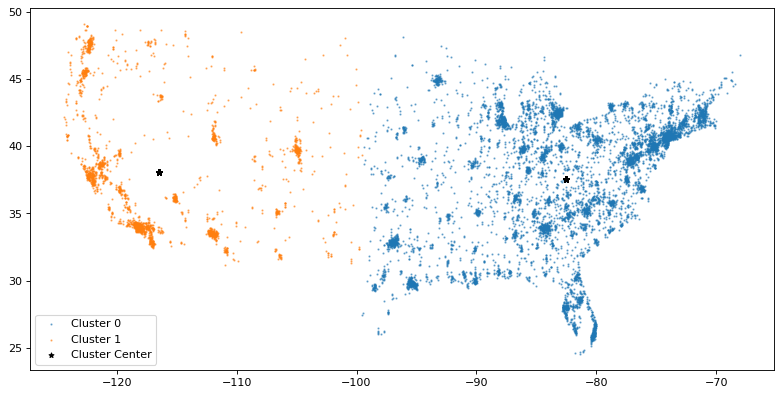

In [0]:
iimport matplotlib.pyplot as plt
from matplotlib.pyplot import figure
k=2
for i in range(k):
    points = np.array(pandas_df.prediction == i])
    plt.scatter(pandas_df.original_longitude[points],pandas_df.original_latitude[points],label="Cluster "+str(i))
plt.scatter(pandas_df.center_longitude,pandas_df.center_latitude,label="Cluster Center",marker="*")
plt.legend()

In [0]:
predictions4_rdd = predictions4.rdd.map(lambda x: (x[0],x[1],x[3],float(centers4[x[3]][0]),float(centers4[x[3]][1])))
df3 = spark.createDataFrame(predictions4_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [0]:
import pyspark.sql.functions as F
df3 = df3.withColumn("a", pow(sin(toRadians(F.col("center_latitude") -F.col( "original_latitude")) / 2), 2) + cos(toRadians(F.col("origin_latitude"))) * cos(toRadians(F.col("centre_latitude"))) * pow(sin(toRadians(F.col("centre_longitude") - F.col("origin_longitude")) / 2), 2))
  .withColumn("gc_dist", atan2(sqrt(F.col("a")), sqrt(-F.col("a") + 1)) * 2 * 6371)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )
                    

In [0]:
df3.rdd.cache()

MapPartitionsRDD[315] at javaToPython at NativeMethodAccessorImpl.java:0

In [0]:
pandas_df = df3.select("*").toPandas()

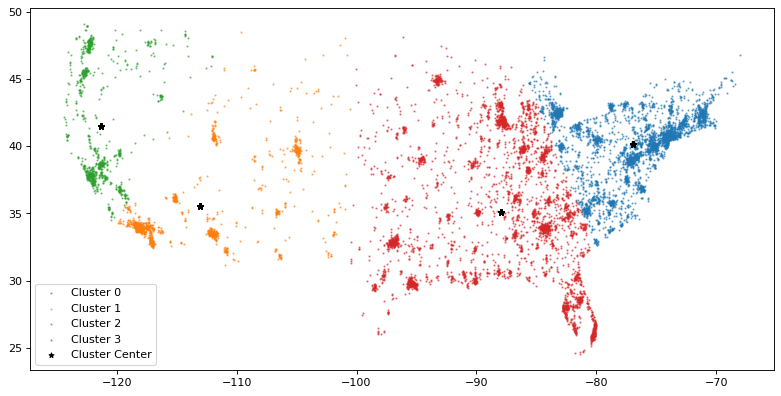

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(4):
    mask = pandas_df.prediction == i
    plt.scatter(pandas_df.original_longitude[mask],pandas_df.original_latitude[mask],label="Cluster "+str(i),alpha=.5)
plt.scatter(pandas_df.center_longitude,pandas_df.center_latitude,label="Cluster Center",s=20,marker="*")
plt.legend()

**dbpedia location data**

In [0]:
input_data="s3://nikhifinalprj6007/lat_longs.txt"

In [0]:
data = sc.textFile(input_data)
parts = data.map(lambda l: l.split(" "))
# Each line is converted to a tuple.
final_data = parts.map(lambda p: (float(p[0]),float(p[1]),StringType(p[2]).strip()))

In [0]:
data.cache()
data.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True),
                                                        types.StructField('Site', types.StringType(),True)

]))

In [0]:
df.show(3)

+---------+---------+--------------------+
| latitude|longitude|                Site|
+---------+---------+--------------------+
|     36.7|3.2166667|<http://dbpedia.o...|
|     42.5|1.5166667|<http://dbpedia.o...|
|12.516666|-70.03333|<http://dbpedia.o...|
+---------+---------+--------------------+
only showing top 3 rows



In [0]:
df.rdd.cache()

MapPartitionsRDD[340] at javaToPython at NativeMethodAccessorImpl.java:0

**kmeans model with K= 4,6**

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X3 = vecAssembler.transform(df)

X3.rdd.cache()

# Model

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X3)

kmeans6 = KMeans().setK(6).setSeed(1)
model6 = kmeans6.fit(X3)


predictions4 = model4.transform(X3)
predictions6 = model6.transform(X3)


predictions4.rdd.cache()
predictions6.rdd.cache()

# Shows the result.

centers4 = model4.clusterCenters()
centers6 = model6.clusterCenters()

print("Cluster Centers K=4: ")
for center in centers4:
    print(center)
print("Cluster Centers K=6: ")
for center in centers4:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))
timetable.append((time.time() - start_time))

Cluster Centers K=4: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]
Cluster Centers K=6: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]
--- 23.092951774597168 seconds ---


In [0]:
predictions4_rdd = predictions4.rdd.map(lambda x: (x[0],x[1],x[4],float(centers4[x[4]][0]),float(centers4[x[4]][1])))
df2 = spark.createDataFrame(predictions4_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))



**code for calculating Great circle distance and euclidean distance**

In [0]:
import pyspark.sql.functions as F
df2 = df2.withColumn("a", pow(sin(toRadians(F.col("center_latitude") -F.col( "original_latitude")) / 2), 2) + cos(toRadians(F.col("origin_latitude"))) * cos(toRadians(F.col("centre_latitude"))) * pow(sin(toRadians(F.col("centre_longitude") - F.col("origin_longitude")) / 2), 2))
  .withColumn("gc_dist", atan2(sqrt(F.col("a")), sqrt(-F.col("a") + 1)) * 2 * 6371)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )
                   

In [0]:
pandas_df = df2.select("*").toPandas()

**cluster visualization**

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


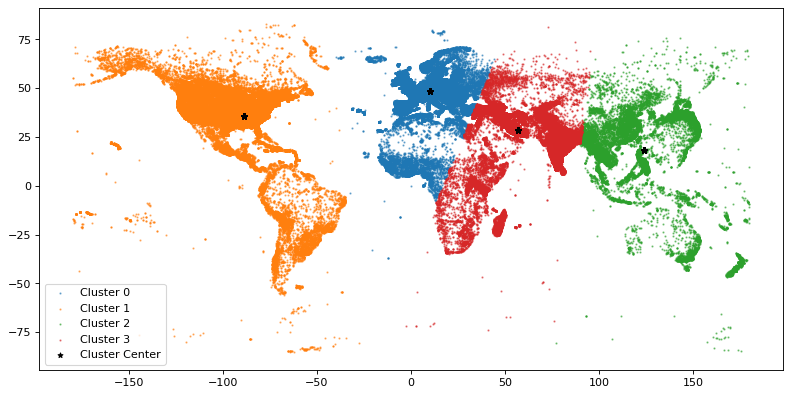

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(4):
    mask = pandas_df.prediction == i
    plt.scatter(pandas_df.original_longitude[mask],pandas_df.original_latitude[mask],label="Cluster "+str(i))
plt.scatter(pandas_df.center_longitude,pandas_df.center_latitude,label="Cluster Center")
plt.legend()

In [0]:
predictions6_rdd = predictions6.rdd.map(lambda x: (x[0],x[1],x[4],float(centers6[x[4]][0]),float(centers6[x[4]][1])))
df3 = spark.createDataFrame(predictions6_rdd, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))



In [0]:
import pyspark.sql.functions as F
df3 = df3.withColumn("a", pow(sin(toRadians(F.col("center_latitude") -F.col( "original_latitude")) / 2), 2) + cos(toRadians(F.col("origin_latitude"))) * cos(toRadians(F.col("centre_latitude"))) * pow(sin(toRadians(F.col("centre_longitude") - F.col("origin_longitude")) / 2), 2))
  .withColumn("gc_dist", atan2(sqrt(F.col("a")), sqrt(-F.col("a") + 1)) * 2 * 6371)\
.drop(F.col("a"))\
.withColumn("eu_dist", F.pow( (F.col('center_latitude') - F.col('original_latitude')  ),2 )+\
                    F.pow( (F.col('center_longitude') - F.col('original_longitude')  ),2 ) )

In [0]:
pandas_df = df3.select("*").toPandas()

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


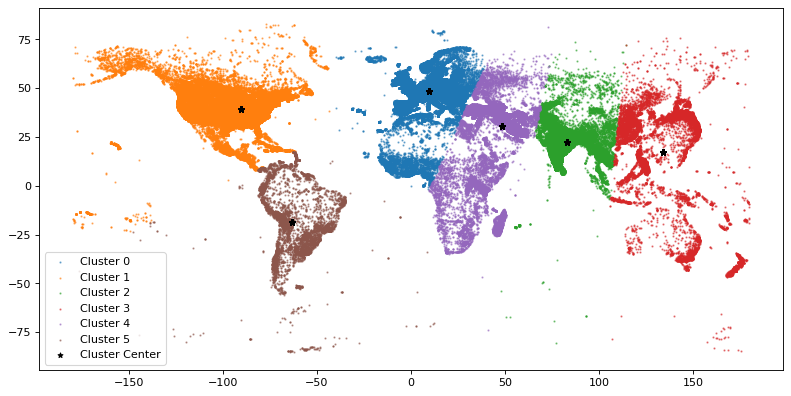

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(6):
    mask = pandas_df.prediction == i
    plt.scatter(pandas_df.original_longitude[mask],pandas_df.original_latitude[mask],label="Cluster "+str(i),alpha=.5)
plt.scatter(pandas_df.center_longitude,pandas_df.center_latitude,label="Cluster Center")
plt.legend()

**time taken to run the models**

In [0]:
timetable

[12.97342848777771, 4.552607297897339, 23.093036890029907]